In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astropy.units as u
import astropy.constants as c
from astropy.table import Table
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from gunagala import camera, optical_filter, optic, psf, sky, imager, utils

/Users/lspitler/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%matplotlib inline

In [3]:
rcParams['figure.figsize'] = 12, 8
rcParams['text.usetex'] = False

## SkyHopper model

Here we construct an approximate performance model programmatically.

### Sky background

As an optical-infrared space telescope the dominant sky background for SkyHopper will be the Zodiacal Light. We can use the model from `gunagala`.

In [4]:
zodiacal_light = sky.ZodiacalLight()

### Telescope

SkyHopper has a ~100 x 200 mm primary mirror, but a primary baffle is planned that will give a kidney bean shaped effective aperture of somewhat less area. `gunagala` currently only supports circular apertures.  For a simple signal to noise calculation assume the effective collecting area is 2.5 times that of Space Eye. To estimate the throughput we use a model from `gunagala` for 4 aluminium mirror surfaces.  The focal length is set to give 4 arcsecond/pixel sampling.

In [5]:
sktp = optic.make_throughput(surfaces=[('aluminium_12deg_protected', 4)])

skyhopper_fl = (18 * u.micron / (4 * u.arcsecond)).to(u.mm, equivalencies=u.equivalencies.dimensionless_angles())

skyhopper_scope = optic.Optic(aperture=90 * 2.5**0.5 * u.mm,
                              focal_length=skyhopper_fl,
                              throughput=sktp)

In [6]:
skyhopper_scope.focal_length

<Quantity 928.1916281119335 mm>

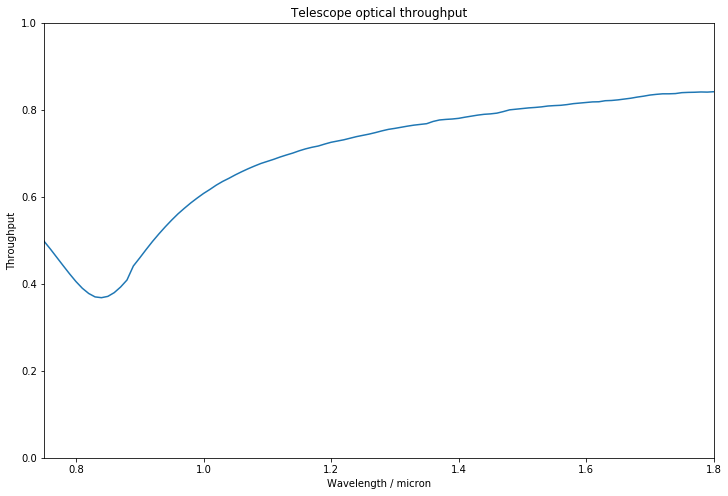

In [7]:
plt.plot(skyhopper_scope.wavelengths.to(u.micron), skyhopper_scope.throughput)
plt.xlim(0.750, 1.800)
plt.ylim(0,1)
plt.xlabel('Wavelength / micron')
plt.ylabel('Throughput')
plt.title('Telescope optical throughput')

### Filters

To accommodate Space Eye science in the SkyHopper design we would add two narrowband filters to the z' channel of SkyHopper, dividing the focal plane equally between these three filters.

Jochen Greiner has provided some simulated filter transmission profiles for the Calcium Triplet 'on' and 'off' filters.  For the prism channels we use the Chebyshev model from `gunagala`, with bandpass edges from the nominal SkyHopper specifications.

In [8]:
skyhopper_z = optical_filter.Filter(chebyshev_params={'order': 35,
                                                      'peak': 0.95 * u.dimensionless_unscaled,
                                                      'ripple': 0.2,
                                                      'wave1': 803 * u.nm,
                                                      'wave2': 947 * u.nm},
                                    apply_aoi=True)

skyhopper_y = optical_filter.Filter(chebyshev_params={'order': 35,
                                                      'peak': 0.95 * u.dimensionless_unscaled,
                                                      'ripple': 0.2,
                                                      'wave1': 953 * u.nm,
                                                      'wave2': 1147 * u.nm},
                                    apply_aoi=True)

skyhopper_j = optical_filter.Filter(chebyshev_params={'order': 35,
                                                      'peak': 0.95 * u.dimensionless_unscaled,
                                                      'ripple': 0.2,
                                                      'wave1': 1153 * u.nm,
                                                      'wave2': 1397 * u.nm},
                                    apply_aoi=True)

skyhopper_h = optical_filter.Filter(chebyshev_params={'order': 35,
                                                      'peak': 0.95 * u.dimensionless_unscaled,
                                                      'ripple': 0.2,
                                                      'wave1': 1403 * u.nm,
                                                      'wave2': 1697 * u.nm},
                                    apply_aoi=True)

In [9]:
CaT_on_table = Table.read('../resources/CaT-on.txt',
                          format='ascii.tab',
                          encoding="ISO-8859-1",
                          names=('Nonsense', 'Rubbish', 'Wavelength', 'Transmission',
                                 'Wavelength again', 'Reflectance'),
                          include_names=('Wavelength', 'Transmission'),
                          header_start=None,
                          data_start=1,
                          fast_reader=False, guess=False)

CaT_on_table['Wavelength'].unit = u.nm
CaT_on_table['Transmission'].unit = u.percent
CaT_on_table['Transmission'] = CaT_on_table['Transmission'].to(u.dimensionless_unscaled)
# CaT filters are in the Z channel, need to include Z transmission profile too.
CaT_on_table['Transmission'] = CaT_on_table['Transmission'] * skyhopper_z.transmission(CaT_on_table['Wavelength'])

In [10]:
CaT_off_table = Table.read('../resources/CaT-off.txt',
                           format='ascii.tab',
                           encoding="ISO-8859-1",
                           names=('Nonsense', 'Rubbish', 'Wavelength', 'Transmission',
                                  'Wavelength again', 'Reflectance'),
                           include_names=('Wavelength', 'Transmission'),
                           header_start=None,
                           data_start=1,
                           fast_reader=False, guess=False)

CaT_off_table['Wavelength'].unit = u.nm
CaT_off_table['Transmission'].unit = u.percent
CaT_off_table['Transmission'] = CaT_off_table['Transmission'].to(u.dimensionless_unscaled)
# CaT filters are in the Z channel, need to include Z transmission profile too.
CaT_off_table['Transmission'] = CaT_off_table['Transmission'] * \
    skyhopper_z.transmission(CaT_off_table['Wavelength'])

In [11]:
CaT_on = optical_filter.Filter(transmission=CaT_on_table, apply_aoi=True)

In [12]:
CaT_off = optical_filter.Filter(transmission=CaT_off_table, apply_aoi=True)

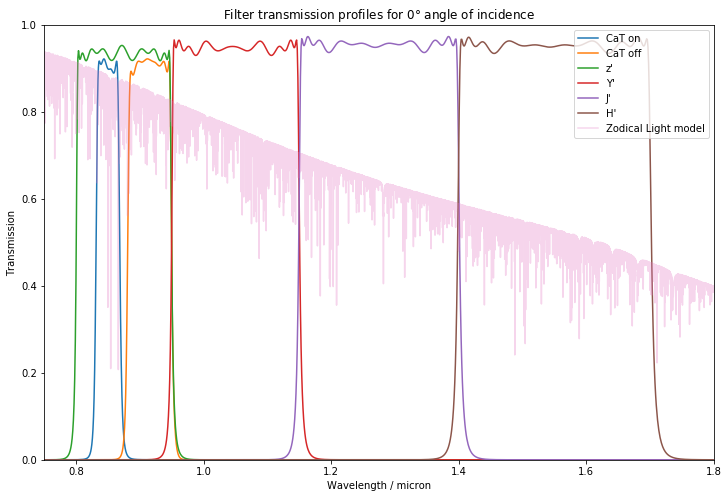

In [13]:
plt.plot(CaT_on_table['Wavelength'].to(u.um), CaT_on_table['Transmission'], label='CaT on')
plt.plot(CaT_off_table['Wavelength'].to(u.um), CaT_off_table['Transmission'], label='CaT off')
waves = np.arange(0.750, 1.800, 0.001) * u.um
plt.plot(waves, skyhopper_z.transmission(waves), label="z'")
plt.plot(waves, skyhopper_y.transmission(waves), label="Y'")
plt.plot(waves, skyhopper_j.transmission(waves), label="J'")
plt.plot(waves, skyhopper_h.transmission(waves), label="H'")
plt.plot(zodiacal_light.waves, zodiacal_light.photon_sfd/60, label='Zodical Light model', alpha=0.3)
plt.xlim(0.750, 1.800)
plt.ylim(0,1)
plt.legend(loc=1)
plt.xlabel('Wavelength / micron')
plt.ylabel('Transmission')
plt.title('Filter transmission profiles for $0\degree$ angle of incidence')
plt.savefig('filters.png')

### Image sensor

SkyHopper will use a Teledyne Hawaii-2RG, 1.7 micron cutoff version. The official specifications (http://www.teledyne-si.com/products/Documents/H2RG%20Brochure%20-%20September%202017.pdf) only give 'minimum' and 'goal' values, which are themselves lower limits.  Here we use the goal values, and assume correlated double sampling readout at 100kHz pixel readout rate, using all 32 readout channels.

Space Eye would probably benefit considerably from up-the-ramp sampling readout, if the SkyHopper image sensor electronics will support it.

For this calculation we only consider the z' channel, which uses 1/4 of the image sensor (2048 x 512 pixels).

In [14]:
ws = [700, 800, 1000, 1230, 1500, 1700, 1800] * u.nm
qes = [0.0, 0.7, 0.7, 0.8, 0.8, 0.8, 0.0] * u.electron / u.photon
h2rgqe = Table(data = [ws, qes], names=['Wavelength', 'QE'])

hawaii2rg = camera.Camera(bit_depth=16,
                          full_well=100000 * u.electron / u.pixel,
                          gain=2 * u.electron / u.adu,
                          bias=0 * u.adu / u.pixel,
                          readout_time=1.25 * u.second,
                          pixel_size=18 * u.micron / u.pixel,
                          resolution=(2048, 512) * u.pixel,
                          read_noise=15 * u.electron / u.pixel,
                          dark_current= 0.01 * u.electron / (u.pixel * u.second),
                          QE=h2rgqe,
                          minimum_exposure=1.25 * u.second)

### Point spread function

This is not used for the extended source signal to noise calculations, but the model requires one. As a placeholder we use a simple Moffat PSF with FWHM of 4 arcseconds.

In [16]:
skyhopper_psf = psf.MoffatPSF(FWHM=4 * u.arcsecond)

### Instrument model

In [17]:
skyhopper = imager.Imager(optic=skyhopper_scope,
                          filters={'Ca_T_on': CaT_on,
                                   'Ca_T_off': CaT_off,
                                   'z': skyhopper_z,
                                   'Y': skyhopper_y,
                                   'J': skyhopper_j,
                                   'H': skyhopper_h},
                          camera=hawaii2rg,
                          sky=zodiacal_light,
                          psf=skyhopper_psf)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


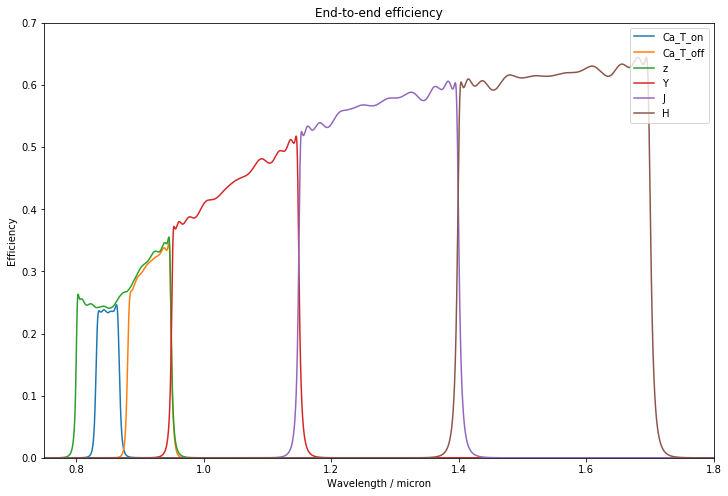

In [18]:
for fname in skyhopper.filter_names:
    plt.plot(skyhopper.wavelengths.to(u.um), skyhopper.efficiencies[fname], label=fname)
plt.xlim(0.750, 1.800)
plt.ylim(0, 0.7)
plt.xlabel('Wavelength / micron')
plt.ylabel('Efficiency')
plt.title('End-to-end efficiency')
plt.legend(loc=1)

The end to end efficiency from this model is broadly constent with the nominal value for SkyHopper of 40%.  The wavelength dependance is significant, and is largely driven by reflectance of the aluminium mirror surfaces.

If gold mirror coatings turn out to be practical they could significantly increase overall performance.

### Point source sensitivity check

The SkyHopper webpage gives a point source sensitivity limit of 19.5 in single 600 second exposure in H band.

In [19]:
skyhopper.point_source_limit(total_exp_time=600*u.second,
                             sub_exp_time=600*u.second,
                             filter_name='H',
                             snr_target=5.0)

<Magnitude 20.387712377468695 mag(AB)>

The 0.9 magnitude difference isn't too alarming, much of it could be due to more pessimistic assumptions about the point spread function, and/or the inclusion of thermal infrared background components from either the sky or the telescope.

### Zodi narrowband S/N check

In [30]:
skyhopper.extended_source_signal_noise(surface_brightness=22. * u.ABmag,
                                       filter_name="Ca_T_on",
                                       total_exp_time=600*u.second,
                                       sub_exp_time=600*u.second)

(<Quantity 144.0640804684974 electron / pix>,
 <Quantity 21.13603774418095 electron / pix>)

In [31]:
skyhopper.extended_source_signal_noise(surface_brightness=22. * u.ABmag,
                                       filter_name="Ca_T_off",
                                       total_exp_time=600*u.second,
                                       sub_exp_time=600*u.second)

(<Quantity 315.5460970355129 electron / pix>,
 <Quantity 26.661136190690073 electron / pix>)



## Cosmic Infrared Background & Zodiacal Light measurements

The Cosmic Infrared Background (CIB) and Zodiacal Light (ZL) are both components of the sky background, with ZL being the dominant one. We aim to measure the absolute surface brightness of both using multiband photometry, taking advantage of the Calcium triplet absorption features in the ZL spectrum.  The Zodiacal Light is expected to have equal Ca-triplet depth to the Solar spectrum while the extragalactic background light will not exhibit any absorption lines. Consequently a measurement of the sky background Ca-triplet absorption depth allows the separation of Zodiacal Light and extragalactic components.

In practice the measurement of the CIB and ZL will be acheived by fitting models to the multiband photometry from SkyHopper. In order to estimate the signal to noise in the fitted parameters we will use a highly simplified model and fitting procedure.

### Cosmic Infrared Background estimate

We base this on predicition for the total Extra-Galactic Background light (EBL) from Driver et al 2018.

In [19]:
ebl = Table.read('../resources/ebl.txt', format='ascii.no_header', names=('Wavelength', 'lambda F_lambda'))
ebl['Wavelength'].unit = u.micron
ebl['lambda F_lambda'].unit = u.nW * u.m**-2 * u.sr**-1

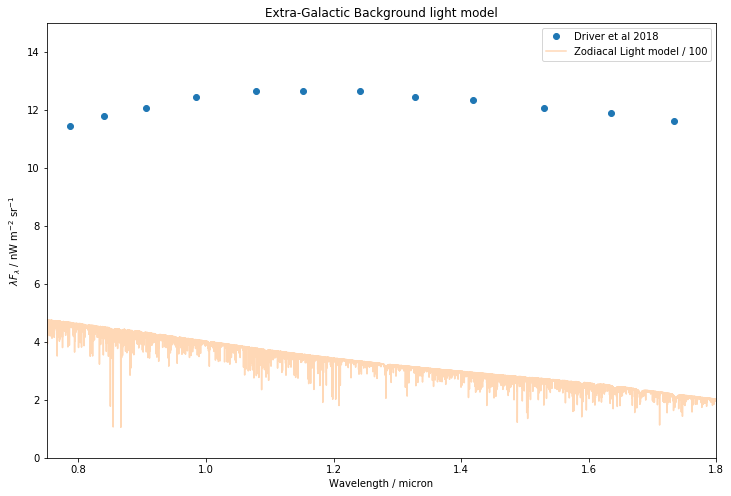

In [44]:
plt.plot(ebl['Wavelength'], ebl['lambda F_lambda'], 'o', label='Driver et al 2018')
plt.plot(zodiacal_light.waves,
         (zodiacal_light.waves * zodiacal_light.sfd).to(u.nW * u.m**-2 * u.sr**-1) / 100,
         alpha=0.3, label='Zodiacal Light model / 100')
plt.xlim(0.75, 1.8)
plt.ylim(0, 15)
plt.xlabel('Wavelength / micron')
plt.ylabel('$\lambda F_\lambda$ / nW m$^{-2}$ sr$^{-1}$')
plt.title('Extra-Galactic Background light model')
plt.legend(loc=1)

The EBL prediction is a flat spectrum at a few percent of the ecliptic pole Zodiacal Light level.

For use with `gunagala` we want to convert to photon spectral flux density units, and create an interpolating function.

In [121]:
ebl_psfd = (ebl['lambda F_lambda'] / (c.h * c.c)) * u.photon
ebl_psfd = ebl_psfd.to(u.photon / (u.s * u.m**2 * u.um * u.sr))
psfd_unit = ebl_psfd.unit

interpolator = interp1d(ebl['Wavelength'], ebl_psfd, kind='cubic')

def ebl_function(wavelength):
    return interpolator(utils.ensure_unit(wavelength, u.um).value) * psfd_unit    

Text(0,0.5,'Spectral flux density / photon s$^{-1}$ m$^{-2}$ um$^{-1}$ sr$^{-1}$')

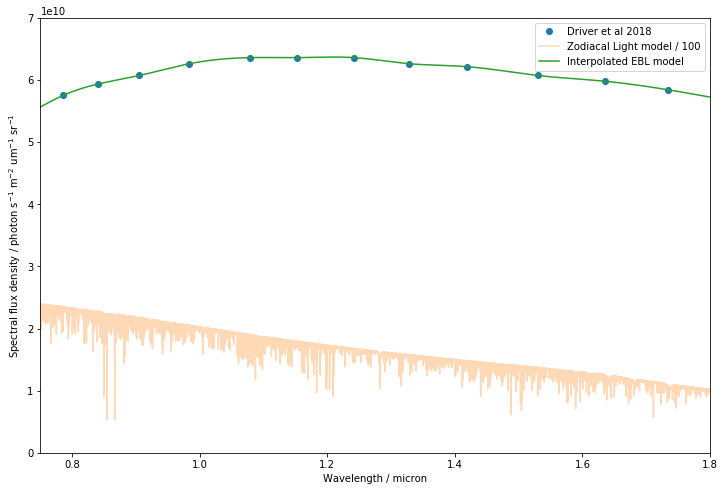

In [123]:
waves = np.arange(0.75, 1.801, 0.001) * u.um
plt.plot(ebl['Wavelength'], ebl_psfd, 'o', label='Driver et al 2018')
plt.plot(zodiacal_light.waves,
         zodiacal_light.photon_sfd.to(u.photon / (u.s * u.m**2 * u.um * u.sr)) / 100,
         alpha=0.3, label='Zodiacal Light model / 100')
plt.plot(waves, ebl_function(waves), '-', label='Interpolated EBL model')

plt.xlim(0.75, 1.8)
plt.ylim(0, 7e10)
plt.legend(loc=1)
plt.xlabel('Wavelength / micron')
plt.ylabel('Spectral flux density / photon s$^{-1}$ m$^{-2}$ um$^{-1}$ sr$^{-1}$')

### Model photometric data

We then use the Zodical Light and Cosmic Infrared Background models to predict total signal and noise as measured in the Space Eye photometric bands.

We assume 6 months of mission time dedicated to EBL observations, with the majority devoted to two low Zodiacal Light and Galactic dust fields (1 in the North, and 1 in the South), an observing duty cycle of 40% and sub exposures of 10 minutes.

The Y, J, H band channels observe the same area of sky simultaneously, each using 2048 x 512 pixels of the image sensor. In the z' channel the image sensor area is divided equally between the z' band and the two CaT filters, each getting an area equivalent to 682 x 512 pixels. A sequence of dithered observations will be required to obtain data on an area of sky with all three z' channel filters, which is essential for the Zodical Light isolaton.

For these simplified calculations we will assume binning of the ZL+EBL signal over the full field of view. In reality we will fit a more sophisticated spatially dependent model with strong priors on spatial variations based on previous observations of the smoothness of the Zodiacal Light. The resulting signal to noise would be similar.

We also multiply by a masking factor to account for the proportion of the sky area that in unusable due to light from discrete sources.  This factor will depend on stray light levels and the sources in and near the actual fields chosen but for now just assume 50% in all cases.

In [124]:
ebl_time = 0.5 * u.year
n_fields = 2
duty_cycle = 0.4
sub_exp_time = 10 * u.minute
masking_factor = 0.5
n_pixels = {'Ca_T_on': 682 * 512,
            'Ca_T_off': 682 * 512,
            'z': 682 * 512,
            'Y': 2048 * 512,
            'J': 2048 * 512,
            'H': 2048 * 512}

total_exp_time = ebl_time * duty_cycle / n_fields

filter_order = ['Ca_T_on', 'Ca_T_off', 'z', 'Y', 'J', 'H']
ebl_signals = []
zl_signals = []
noises = []

for filter_name in filter_order:
    ebl_signal, noise = skyhopper.extended_source_signal_noise(surface_brightness=ebl_function,
                                                               filter_name=filter_name,
                                                               total_exp_time=total_exp_time,
                                                               sub_exp_time=sub_exp_time,
                                                               calc_type='per pixel',
                                                               binning=n_pixels[filter_name] * masking_factor)
    zl_signal, noise_again = skyhopper.extended_source_signal_noise(surface_brightness=None,
                                                                    filter_name=filter_name,
                                                                    total_exp_time=total_exp_time,
                                                                    sub_exp_time=sub_exp_time,
                                                                    calc_type='per pixel',
                                                                    binning=n_pixels[filter_name] * masking_factor)
    zl_signals.append(zl_signal * u.pixel)
    ebl_signals.append(ebl_signal * u.pixel)
    noises.append(noise * u.pixel)
    
ebl_signals = u.Quantity(ebl_signals)
zl_signals = u.Quantity(zl_signals)
noises = u.Quantity(noises)

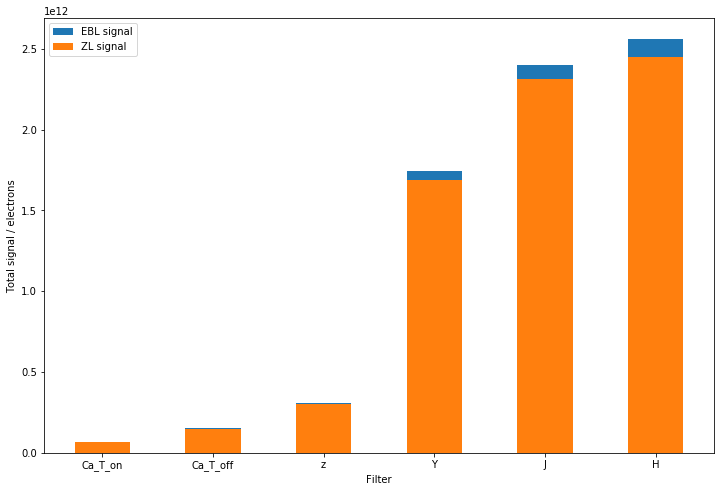

In [125]:
indices = np.arange(len(filter_order))
width=0.5

plt.bar(indices, ebl_signals.value, width, bottom=zl_signals.value, yerr=noises.value, label='EBL signal')
plt.bar(indices, zl_signals.value, width, label='ZL signal')
plt.xticks(indices, filter_order)
plt.xlabel('Filter')
plt.ylabel('Total signal / electrons')
plt.legend(loc=2)
plt.title('');

### Sensitivity estimates

To estimate the signal to noise in the measurements of the Zodiacal Light and cosmic infrared background we use the photometric model to generate sets of simulated data with noise then fit as simple model to the noisy data in order to recover the Zodiacal Light flux and EBL spectrum. Using a brute force Monte Carlo method we can obtain a simple estimate of the uncertainty in the recovered measurements